# Investigating the emergence of complementary knowledge and specialization across models

# Preliminaries

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import utils
import data_utils

/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utility functions

In [6]:
import torch

def get_predictions(model, test_loader, compute_probabilities=True):
    inpts, targets, predictions, logits = [], [], [], []
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)

            lgts = outputs
            if compute_probabilities:
                lgts = torch.nn.functional.log_softmax(outputs, dim=1)

            max, predicted = torch.max(lgts, 1)

            inpts.extend(inputs)
            targets.extend(labels.detach())
            predictions.extend(predicted.detach())
            logits.extend(max)  #TODO beware of the fact that the logits in the case of SimpleNN are not actual logits!

            # print(max[0], predicted[0], max[0]+predicted[0])

            # compute model's accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total

    return inpts, targets, predictions, logits, accuracy

In [115]:
def run_compl_knowledge_analysis(config, **kwarg):
    # load dataloaders
    utils.set_seed(0)
    train_loaders, test_loaders = data_utils.create_rotated_mnist_task(config['num_tasks'], config['per_task_rotation'], config['batch_size'])

    lst_compl_knowledge, lst_accuracy_diff = [], []

    for model_id in range(config['num_tasks']):
        # choose models to compare
        #model_id = 1
        test_loader_1 = test_loaders[model_id]
        rot_1 = test_loader_1['rot']
        print('rotation_1', rot_1)

        # load model
        model_1_path = '0_SeparateModel/{}/{}_{}_{}deg_MNIST.pth'.format(
            config['model_name'],
            config['setting'],
            config['model_name'],
            rot_1
            )
        model_1 = utils.load_model(path=model_1_path)

        # compute predictions
        inputs_1, targets_1, predictions_1, logits_1, accuracy_1 = get_predictions(model_1, test_loader_1['loader'])


        for i in range(config['num_tasks']):

            if i == model_id:
                continue


            # choose the other model to compare to
            test_loader_2 = test_loaders[i]
            rot_2 = test_loader_2['rot']
            print('rotation_2', rot_2)

            # load model
            model_2_path = '0_SeparateModel/{}/{}_{}_{}deg_MNIST.pth'.format(
                config['model_name'],
                config['setting'],
                config['model_name'],
                rot_2
                )
            model_2 = utils.load_model(path=model_2_path)

            # compute predictions
            inputs_2, targets_2, predictions_2, logits_2, accuracy_2 = get_predictions(model_2, test_loader_2['loader'])


            np_targets_1 = np.array(targets_1)
            np_targets_2 = np.array(targets_2)
            np_preds_1 = np.array(predictions_1)
            np_preds_2 = np.array(predictions_2)
            np_logits_1 = np.array(logits_1)
            np_logits_2 = np.array(logits_2)

            #print(np_targets_1)
            #print(np_targets_2)
            assert np.all(np.equal(np_targets_1, np_targets_2))

            #----------------------------------------------------------------------------------------------------------------------------
            bien_bien_preds = np.logical_and(np_preds_1==np_targets_1, np_preds_2==np_targets_2)
            bien_mal_preds = np.logical_and(np_preds_1==np_targets_1, np_preds_2!=np_targets_2)
            mal_bien_preds = np.logical_and(np_preds_1!=np_targets_1, np_preds_2==np_targets_2)
            mal_mal_preds = np.logical_and(np_preds_1!=np_targets_1, np_preds_2!=np_targets_2)
            #print(bien_bien_preds)
            #print(bien_mal_preds)

            #----------------------------------------------------------------------------------------------------------------------------
            # Complementary knowledge between the pair of models
            # "positive flip. This quantifies the proportion of samples correctly classified by the teacher but incorrectly by the student - the complementary knowledge"
            # Here, there is no notion of student or teacher. We only deal with models in general.
            positive_flips = bien_mal_preds.sum()
            compl_knowledge = positive_flips/len(bien_bien_preds)
            print('Complementary knowledge between {}°-{} (acc: {}%) and {}°-{} (acc: {}%) is {}'.format(
                rot_1, config['model_name'], accuracy_1,
                rot_2, config['model_name'], accuracy_2,
                compl_knowledge
            ))

            acc_diff = accuracy_1-accuracy_2

            #----------------------------------------------------------------------------------------------------------------------------
            # for each pair of models, plot the sorted histograms of complementary knowledge per class
            fix, ax = plt.subplots(figsize=plt.figaspect(1.5))
            hist, bin_edges = np.histogram(np_targets_1[bien_mal_preds], bins=10)
            #print(hist.shape, bin_edges.shape)
            plt.bar(np.sort(bin_edges[:-1]), np.sort(hist)[::-1], align='center', ec='tab:blue', alpha=0.5)
            plt.title('Perf. Diff.: {:.4}'.format(acc_diff), fontsize=18)
            plt.xlabel('Classes', fontsize=15)
            plt.ylabel('Complementary Knowledge \n [number of examples]', fontsize=15)
            plt.xticks([])
            plt.show()

            #----------------------------------------------------------------------------------------------------------------------------
            lst_compl_knowledge.append(compl_knowledge)
            lst_accuracy_diff.append(acc_diff)


    #--------------------------------------------------------------------------------
    # plot complementary knowledge vs. performance (accuracy) difference
    plt.scatter(lst_accuracy_diff, lst_compl_knowledge, facecolors='none', edgecolors='b')
    xlim = max([max(lst_accuracy_diff), -min(lst_accuracy_diff)])
    plt.title('{}'.format(config['model_name']), fontsize=18)
    plt.ylabel('Complementary knowledge %', fontsize=15)
    plt.xlabel('Performance difference', fontsize=15)
    plt.xlim([-xlim, +xlim])
    plt.axvline(x=0, linestyle='--', linewidth=1, color='grey')
    path = '0_SeparateModel/{}_{}_complementary_knowledge_vs_performance_difference.pdf'.format(
        config['setting'],
        config['model_name'],
    )
    plt.savefig(path, bbox_inches='tight')
    plt.show()
    #--------------------------------------------------------------------------------
    


    return lst_compl_knowledge, lst_accuracy_diff




# NN

In [116]:
config = {
    # ---COMMON----
    'setting': 'SeparateModel',
    'model_name': 'SimpleNN',
    'num_tasks': 8, 'per_task_rotation': 45,
    # 'trial': TRIAL_ID, 'exp_dir': EXP_DIR,\
    # 'memory_size': 200, 'dataset': DATASET, 'device': DEVICE, 'momentum': 0.8,\
    # 'mlp_hiddens': HIDDENS, 'dropout': 0.2, 'lr_decay': 0.8, 'stable_sgd': False,\
    'batch_size': 64,\
    'rounds': 10
}
config['rotations'] = [(task-1) * config['per_task_rotation'] for task in range(config['num_tasks'])]  #consistent with the code of `create_rotated_mnist`
print(config['rotations'])


[-45, 0, 45, 90, 135, 180, 225, 270]


Random seed set as 0
rotation_1 -45
rotation_2 0
Complementary knowledge between -45°-SimpleNN (acc: 0.972%) and 0°-SimpleNN (acc: 0.9726%) is 0.0102


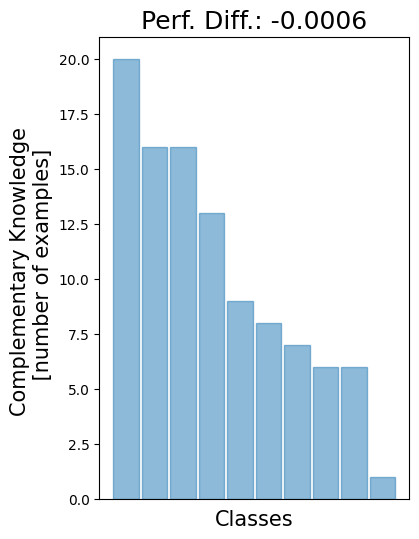

rotation_2 45
Complementary knowledge between -45°-SimpleNN (acc: 0.972%) and 45°-SimpleNN (acc: 0.9711%) is 0.0107


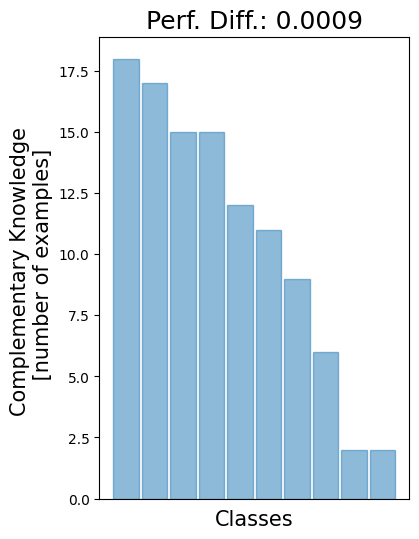

rotation_2 90
Complementary knowledge between -45°-SimpleNN (acc: 0.972%) and 90°-SimpleNN (acc: 0.9669%) is 0.0146


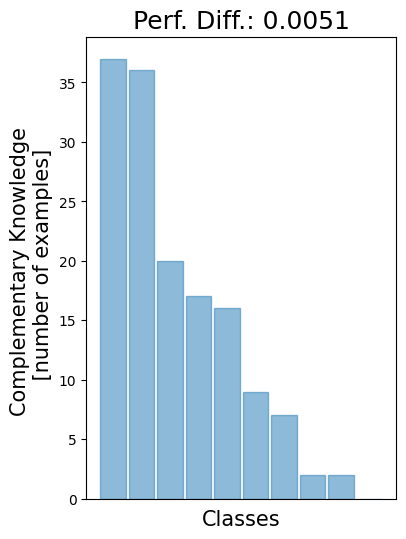

rotation_2 135
Complementary knowledge between -45°-SimpleNN (acc: 0.972%) and 135°-SimpleNN (acc: 0.9724%) is 0.0097


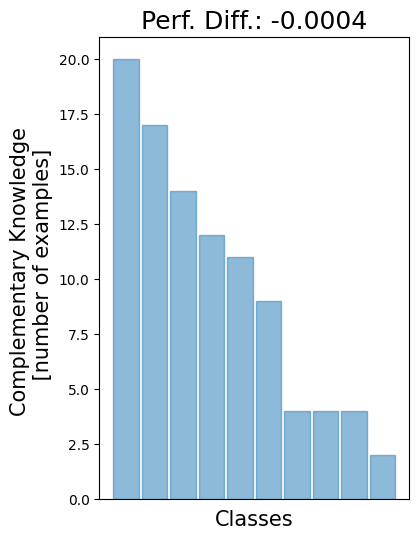

rotation_2 180
Complementary knowledge between -45°-SimpleNN (acc: 0.972%) and 180°-SimpleNN (acc: 0.9708%) is 0.0104


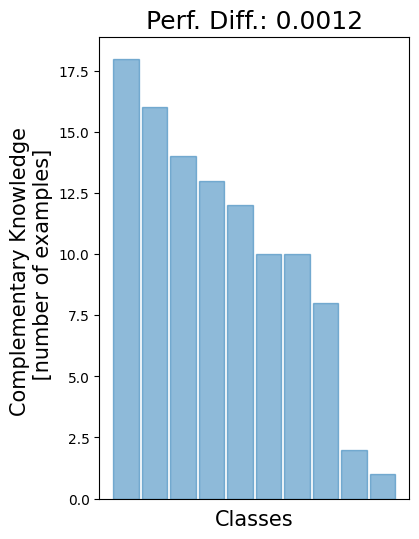

rotation_2 225
Complementary knowledge between -45°-SimpleNN (acc: 0.972%) and 225°-SimpleNN (acc: 0.9741%) is 0.0083


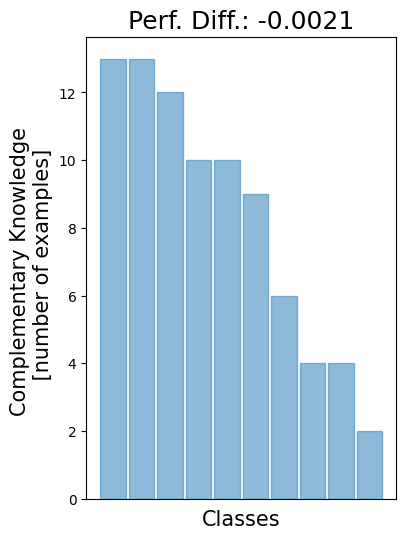

rotation_2 270
Complementary knowledge between -45°-SimpleNN (acc: 0.972%) and 270°-SimpleNN (acc: 0.9691%) is 0.012


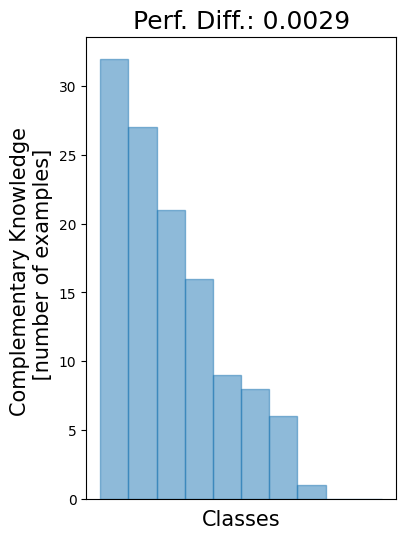

rotation_1 0
rotation_2 -45
Complementary knowledge between 0°-SimpleNN (acc: 0.9726%) and -45°-SimpleNN (acc: 0.972%) is 0.0108


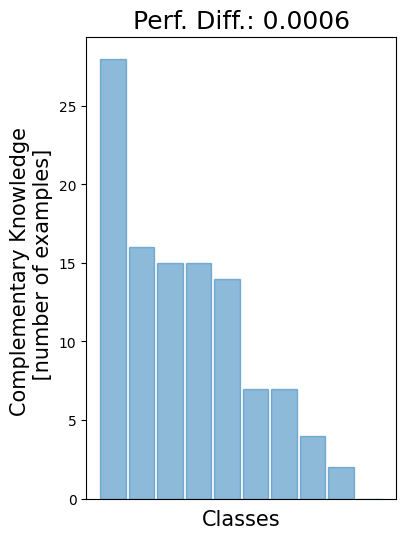

rotation_2 45
Complementary knowledge between 0°-SimpleNN (acc: 0.9726%) and 45°-SimpleNN (acc: 0.9711%) is 0.0099


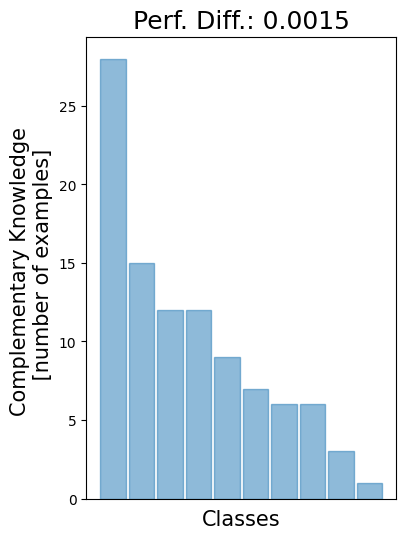

rotation_2 90
Complementary knowledge between 0°-SimpleNN (acc: 0.9726%) and 90°-SimpleNN (acc: 0.9669%) is 0.0142


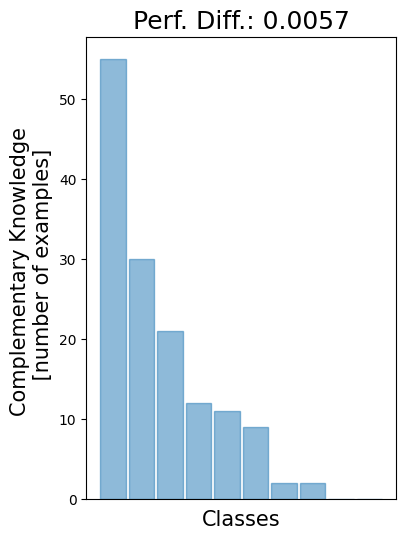

rotation_2 135
Complementary knowledge between 0°-SimpleNN (acc: 0.9726%) and 135°-SimpleNN (acc: 0.9724%) is 0.0104


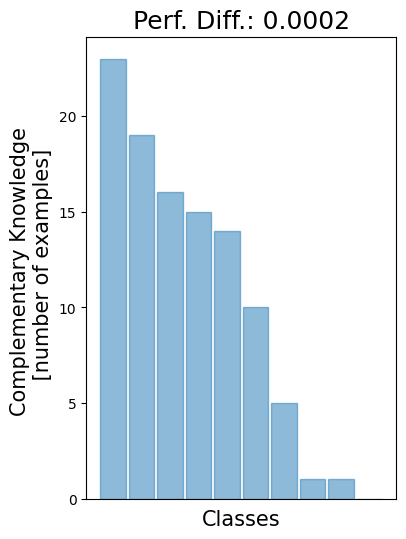

rotation_2 180
Complementary knowledge between 0°-SimpleNN (acc: 0.9726%) and 180°-SimpleNN (acc: 0.9708%) is 0.0115


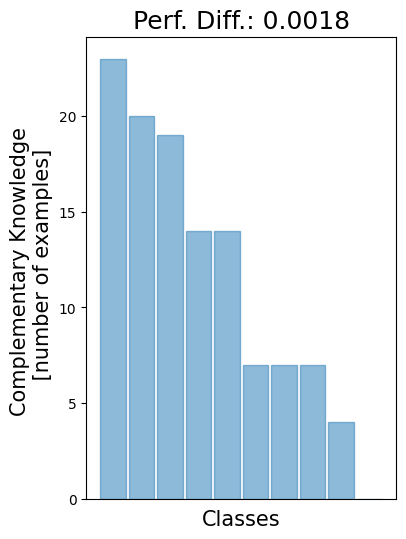

rotation_2 225
Complementary knowledge between 0°-SimpleNN (acc: 0.9726%) and 225°-SimpleNN (acc: 0.9741%) is 0.0087


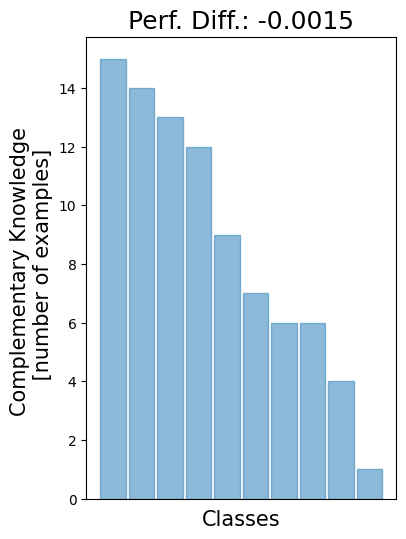

rotation_2 270


KeyboardInterrupt: 

In [117]:
lst_compl_knowledge, lst_accuracy_diff = run_compl_knowledge_analysis(config=config)

# CNN

In [56]:
config = {
    # ---COMMON----
    'setting': 'SeparateModel',
    'model_name': 'SimpleCNN',
    'num_tasks': 8, 'per_task_rotation': 45,
    # 'trial': TRIAL_ID, 'exp_dir': EXP_DIR,\
    # 'memory_size': 200, 'dataset': DATASET, 'device': DEVICE, 'momentum': 0.8,\
    # 'mlp_hiddens': HIDDENS, 'dropout': 0.2, 'lr_decay': 0.8, 'stable_sgd': False,\
    'batch_size': 64,\
    'rounds': 10
}
config['rotations'] = [(task-1) * config['per_task_rotation'] for task in range(config['num_tasks'])]  #consistent with the code of `create_rotated_mnist`
print(config['rotations'])


[-45, 0, 45, 90, 135, 180, 225, 270]


Random seed set as 0
rotation_1 -45
rotation_2 0
Complementary knowledge between -45°-SimpleCNN (acc: 0.9883%) and 0°-SimpleCNN (acc: 0.9887%) is 0.004
rotation_2 45
Complementary knowledge between -45°-SimpleCNN (acc: 0.9883%) and 45°-SimpleCNN (acc: 0.9876%) is 0.0048
rotation_2 90
Complementary knowledge between -45°-SimpleCNN (acc: 0.9883%) and 90°-SimpleCNN (acc: 0.9915%) is 0.0027
rotation_2 135
Complementary knowledge between -45°-SimpleCNN (acc: 0.9883%) and 135°-SimpleCNN (acc: 0.9897%) is 0.0033
rotation_2 180
Complementary knowledge between -45°-SimpleCNN (acc: 0.9883%) and 180°-SimpleCNN (acc: 0.9894%) is 0.0047
rotation_2 225
Complementary knowledge between -45°-SimpleCNN (acc: 0.9883%) and 225°-SimpleCNN (acc: 0.9896%) is 0.0031
rotation_2 270
Complementary knowledge between -45°-SimpleCNN (acc: 0.9883%) and 270°-SimpleCNN (acc: 0.9909%) is 0.0038
rotation_1 0
rotation_2 -45
Complementary knowledge between 0°-SimpleCNN (acc: 0.9887%) and -45°-SimpleCNN (acc: 0.9883%) is 0

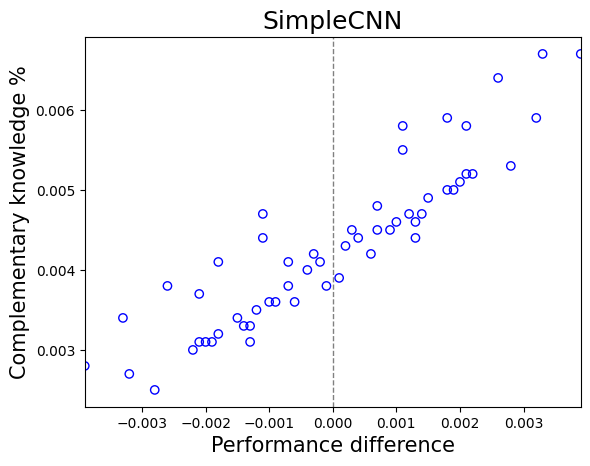

In [57]:
lst_compl_knowledge, lst_accuracy_diff = run_compl_knowledge_analysis(config=config)